$\textbf{Question 1:}$

$\textbf{Your Answer: }$
Diagonal approximation to the Hessian matrix $\nabla^2f( \mathbf{x})$, i.e., the diagonal matrix $\mathbf{D}^k$ that has the inverse second partial derivatives $\Big(\frac{\partial^2f(\mathbf{x_k})}{(\partial x_i)^2}\Big)^{-1}$ along the diagonal. This improves the performance of the gradient method dramatically, by providing automatic scaling of the units in which the components $x_i$ of $\mathbf{x}$ are measured. Because of such choice of $\mathbf{D}^k$, the condition number of $\mathbf{Q}$ is improving and becoming so close to $1$ so that our gradient descent scheme is converging so quickly. Here, product with inverse of diagonal elements of hessian matrix with hessian matrix is causing the improvements in $\mathbf{Q}$ by becoming so close to condition number of identity matrix. This is so helpful in fasterness of the algorithm.
$H^k = \nabla ^2 f(x) =
 \begin{bmatrix}
 \frac{\delta ^2}{\delta x_1 ^2} f(x) &
 \frac{\delta ^2}{\delta x_1 \delta x_2} f(x) \\
 \frac{\delta ^2}{\delta x_1 \delta x_2} f(x) &
 \frac{\delta ^2} {\delta x_2 ^2} f(x)
 \end{bmatrix}=
 \begin{bmatrix}
 6144x_1^2 - 2048x_2 + 2 &
 -2048x_1 \\
 -2048x_1 &
 1024
 \end{bmatrix}
$ \\
$\text{From this we obtain}$ \\
$\therefore \mathbf{D^k} =
\begin{bmatrix}
  \frac{1}{6144x_1^2 - 2048x_2 + 2} & 0 \\ 0 & \frac{1}{1024}
\end{bmatrix}$

Code to find the matrix $\mathbf{D}^k$. 

In [19]:
import numpy as np

#method to find Hessian matrix
def evalh(x): 
  assert type(x) is np.ndarray 
  assert len(x) == 2
  return np.array([[6144*(x[0])**2 - 2048*x[1] + 2, -2048*x[0]], [-2048*x[0], 1024]])

#method to find the condition number of any square matrix
def find_condition_number(A):
  assert type(A) is np.ndarray
  assert A.shape[0] == A.shape[1]
  return np.linalg.cond(A)

In [20]:
#The method defines a way to construct D_k matrix used in scaling the gradient in the modified gradient descent scheme
def compute_D_k_diag(x):
  assert type(x) is np.ndarray
  assert len(x) == 2
  A = evalh(x)
  B = np.array([[1/A[0][0], 0], [0, 1/A[1][1]]])
  return B

In [21]:
def evalf(x):  
  #Input: x is a numpy array of size 2 
  assert type(x) is np.ndarray and len(x) == 2 #do not allow arbitrary arguments
  #after checking if the argument is valid, we can compute the objective function value
  #compute the function value and return it
  return 512 * (x[1] - x[0]**2)**2 + (4 - x[0])**2

In [22]:
def evalg(x):  
  #Input: x is a numpy array of size 2 
  assert type(x) is np.ndarray and len(x) == 2 #do not allow arbitrary arguments 
  #after checking if the argument is valid, we can compute the gradient value
  #compute the gradient value and return it 
  a = (-2048 * x[0] * (x[1] - x[0]**2)) - (2 * (4 - x[0]))
  b = 1024 * (x[1] - x[0]**2)
  return np.array([a, b])

In [23]:
#Complete the module to compute the steplength by using the closed-form expression
def compute_steplength_backtracking(x, gradf, alpha_start, rho, gamma): #add appropriate arguments to the function 
  assert type(x) is np.ndarray and len(gradf) == 2 
  assert type(gradf) is np.ndarray and len(gradf) == 2 
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  alpha = alpha_start
  p = - gradf
  #implement the backtracking line search
  #print(evalf(x + alpha*p), evalf(x) + gamma * alpha* (np.matmul(np.matrix.transpose(p), p) ))
  while evalf(x + alpha*p) > evalf(x) + gamma * alpha* (np.matmul(np.matrix.transpose(gradf), p) ):
    alpha = alpha * rho
  return alpha
  #Complete the code

In [24]:
def compute_steplength_backtracking_scaled_direction(x, gradf, alpha_start, rho, gamma): #add appropriate arguments to the function 
  assert type(x) is np.ndarray and len(gradf) == 2 
  assert type(gradf) is np.ndarray and len(gradf) == 2 
  #assert type(direction) is np.ndarray and len(direction) == 2 
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  alpha = alpha_start
  p = - gradf
  D_k = compute_D_k_diag(x)
  #implement the backtracking line search
  #print(evalf(x + alpha*p), evalf(x) + gamma * alpha* (np.matmul(np.matrix.transpose(p), p) ))
  while evalf(x + alpha*np.matmul(D_k,p)) > evalf(x) + gamma * alpha* (np.matmul(np.matrix.transpose(gradf), np.matmul(D_k,p)) ):
    alpha = alpha * rho
  return alpha
  #Complete the code 

In [25]:
EXACT_LINE_SEARCH = 1
BACKTRACKING_LINE_SEARCH = 2
CONSTANT_STEP_LENGTH = 3

In [26]:
#complete the code for gradient descent to find the minimizer
def find_minimizer_gd(start_x, tol, line_search_type, *args):
  #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
  assert type(start_x) is np.ndarray and len(start_x) == 2 #do not allow arbitrary arguments 
  assert type(tol) is float and tol>=0 
  x = start_x
  g_x = evalg(x)
  A = evalh(x)/2
  #initialization for backtracking line search
  if(line_search_type == BACKTRACKING_LINE_SEARCH):
    alpha_start = args[0]
    rho = args[1]
    gamma = args[2]
    #print('Params for Backtracking LS: alpha start:', alpha_start, 'rho:', rho,' gamma:', gamma)
  condition_number_array = []
  k = 0
  #print('iter:',k, ' x:', x, ' f(x):', evalf(x), ' grad at x:', g_x, ' gradient norm:', np.linalg.norm(g_x))
  data1=[]
  while (np.linalg.norm(g_x) > tol): #continue as long as the norm of gradient is not close to zero upto a tolerance tol
    condition_number_array.append(find_condition_number(evalh(x)))
    if line_search_type == EXACT_LINE_SEARCH:
      step_length = compute_steplength_exact(g_x, A) #call the new function you wrote to compute the steplength
      #raise ValueError('EXACT LINE SEARCH NOT YET IMPLEMENTED')
    elif line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking(x, g_x, alpha_start, rho, gamma) #call the new function you wrote to compute the steplength
      #raise ValueError('BACKTRACKING LINE SEARCH NOT YET IMPLEMENTED')
    elif line_search_type == CONSTANT_STEP_LENGTH: #do a gradient descent with constant step length
      step_length = 0.1
    else:  
      raise ValueError('Line search type unknown. Please check!')
    
    #implement the gradient descent steps here  
    x = np.subtract(x, np.multiply(step_length, g_x)) #update x = x - step_length*g_x
    k += 1 #increment iteration
    g_x = evalg(x) #compute gradient at new point
    data1.append([k, x, evalf(x), np.linalg.cond(evalh(x))])
  return x, k, condition_number_array, data1
  #Complete the code 

In [27]:
#complete the code for gradient descent with scaling to find the minimizer

def find_minimizer_gdscaling(start_x, tol, line_search_type, *args):
  #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
  assert type(start_x) is np.ndarray and len(start_x) == 2 #do not allow arbitrary arguments 
  assert type(tol) is float and tol>=0 
  x = start_x
  g_x = evalg(x)
  #A = evalh(x)/2

  #initialization for backtracking line search
  if(line_search_type == BACKTRACKING_LINE_SEARCH):
    alpha_start = args[0]
    rho = args[1]
    gamma = args[2]
    #print('Params for Backtracking LS: alpha start:', alpha_start, 'rho:', rho,' gamma:', gamma)
  k = 0
  while (np.linalg.norm(g_x) > tol): #continue as long as the norm of gradient is not close to zero upto a tolerance tol
    D_k = compute_D_k_diag(x)
    if line_search_type == EXACT_LINE_SEARCH:
      step_length = compute_steplength_exact(g_x, A) #call the new function you wrote to compute the steplength
      #raise ValueError('EXACT LINE SEARCH NOT YET IMPLEMENTED')
    elif line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x, g_x, alpha_start, rho, gamma) #call the new function you wrote to compute the steplength
      #raise ValueError('BACKTRACKING LINE SEARCH NOT YET IMPLEMENTED')
    elif line_search_type == CONSTANT_STEP_LENGTH: #do a gradient descent with constant step length
      step_length = 0.1
    else:  
      raise ValueError('Line search type unknown. Please check!')
    
    #implement the gradient descent steps here  
    x = np.subtract(x, np.multiply(step_length,np.matmul(D_k, g_x))) #update x = x - step_length*g_x
    k += 1 #increment iteration
    g_x = evalg(x) #compute gradient at new point
    
  return x, k
  #Complete the code  

In [28]:
my_start_x = np.array([8,8])
my_tol= 1e-5

In [29]:
alpha_start = 1.
rho = 0.5
gamma = 0.5
print("\nUsing Gradient descent with Backtracking Line Search")
#check what happens when you call find_minimzer using backtracking line search
x_opt_bls, k, p, data1 = find_minimizer_gd(my_start_x, my_tol, BACKTRACKING_LINE_SEARCH, alpha_start, rho, gamma)
print("Minimizer: {}, Minimum function value: {}".format((x_opt_bls[0], x_opt_bls[1]), evalf(x_opt_bls)),"\nNo. of Iterations:", k)


Using Gradient descent with Backtracking Line Search
Minimizer: (3.9999597839949743, 15.999678263984114), Minimum function value: 1.6173741774296086e-09 
No. of Iterations: 902339


In [30]:
alpha_start = 1.
rho = 0.5
gamma = 0.5
print("\nUsing Gradient descent with scaling and Backtracking Line Search")
#check what happens when you call find_minimzer using backtracking line search
x_opt_bls, k = find_minimizer_gdscaling(my_start_x, my_tol, BACKTRACKING_LINE_SEARCH, alpha_start, rho, gamma)
print("Minimizer: {}, Minimum function value: {}".format((x_opt_bls[0], x_opt_bls[1]), evalf(x_opt_bls)),"\nNo. of Iterations:", k)


Using Gradient descent with scaling and Backtracking Line Search
Minimizer: (4.000009925130873, 16.00007940235738), Minimum function value: 9.850897480037126e-11 
No. of Iterations: 904703


$\text{In case of Gradient descent line search (without scaling) and (with scaling) the number of iterations are almost same (902339~without scaling and 904703~with scaling). Therefore, inspite of small no. of iterations in case of scaling, it's actually increased a bit.} \\ \text{The minimizer in case of gradient descent line search is (3.9999597839949743, 15.999678263984114) and using scaling is (4.000009925130873, 16.00007940235738).}\\ \text{Also, the minimum function value is a bit less when used scaling.}$

$\text{}$

$\textbf{Question 3:}$

$\text{Based on our discussion on condition number and the derivation of the gradient descent scheme with
scaling, the matrix Q whose condition number needs to be analyzed will be in the form:}$
$\mathbf{Q}$  = $(\mathbf{D}^k)^{\frac{1}{2}} \mathbf{H}^k (\mathbf{D}^k)^{\frac{1}{2}}$

Where,
$H = \nabla ^2 f(x) =
 \begin{bmatrix}
 \frac{\delta ^2}{\delta x_1 ^2} f(x) &
 \frac{\delta ^2}{\delta x_1 \delta x_2} f(x) \\
 \frac{\delta ^2}{\delta x_1 \delta x_2} f(x) &
 \frac{\delta ^2} {\delta x_2 ^2} f(x)
 \end{bmatrix}=
 \begin{bmatrix}
 6144x_1^2 - 2048x_2 + 2 &
 -2048x_1 \\
 -2048x_1 &
 1024
 \end{bmatrix}
$
and $ \mathbf{H}^k = (\nabla^2f(\mathbf{x})) $ is the hessian matrix of a function at each iteration.

Because of such choice of $\mathbf{Q}$, condition number of in the gradient descent scheme is decreasing almost to $1$ so that out algorithm with scaling becomes so fast.

$\textbf{Question 4:}$

In [31]:
def compute_D_k(x):
  assert type(x) is np.ndarray
  assert len(x) == 2
  if np.linalg.det(evalh(x)) != 0:
    return np.linalg.inv(evalh(x))

In [32]:
def compute_steplength_backtracking_scaled_direction_newton(x, gradf, alpha_start, rho, gamma): #add appropriate arguments to the function 
  assert type(x) is np.ndarray and len(gradf) == 2 
  assert type(gradf) is np.ndarray and len(gradf) == 2 
  #assert type(direction) is np.ndarray and len(direction) == 2 
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  alpha = alpha_start
  p = - gradf
  D_k = compute_D_k(x)
  #implement the backtracking line search
  #print(evalf(x + alpha*p), evalf(x) + gamma * alpha* (np.matmul(np.matrix.transpose(p), p) ))
  while evalf(x + alpha*np.matmul(D_k,p)) > evalf(x) + gamma * alpha* (np.matmul(np.matrix.transpose(gradf), np.matmul(D_k,p)) ):
    alpha = alpha * rho
  return alpha 

In [33]:
#complete the code for gradient descent with scaling to find the minimizer

def find_minimizer_gdscaling_newton(start_x, tol, line_search_type, *args):
  #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
  assert type(start_x) is np.ndarray and len(start_x) == 2 #do not allow arbitrary arguments 
  assert type(tol) is float and tol>=0 
  x = start_x
  g_x = evalg(x)
  condition_number_array_scaling = []
  #initialization for backtracking line search
  if(line_search_type == BACKTRACKING_LINE_SEARCH):
    alpha_start = args[0]
    rho = args[1]
    gamma = args[2]
    #print('Params for Backtracking LS: alpha start:', alpha_start, 'rho:', rho,' gamma:', gamma)
  data=[]
  k = 0
  while (np.linalg.norm(g_x) > tol): #continue as long as the norm of gradient is not close to zero upto a tolerance tol
    D_k = compute_D_k(x)
    import scipy
    from scipy.linalg import sqrtm
    d = scipy.linalg.sqrtm(D_k)
    C1 = np.matmul(np.matmul(d,evalh(x)),d)
    #print("Iteration", k, ", Condition Number:", find_condition_number(C1), ", x:", x)
    condition_number_array_scaling.append(find_condition_number(C1))
    if line_search_type == EXACT_LINE_SEARCH:
      step_length = compute_steplength_exact(g_x, A) #call the new function you wrote to compute the steplength
      #raise ValueError('EXACT LINE SEARCH NOT YET IMPLEMENTED')
    elif line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction_newton(x, g_x, alpha_start, rho, gamma) #call the new function you wrote to compute the steplength
      #raise ValueError('BACKTRACKING LINE SEARCH NOT YET IMPLEMENTED')
    elif line_search_type == CONSTANT_STEP_LENGTH: #do a gradient descent with constant step length
      step_length = 0.1
    else:  
      raise ValueError('Line search type unknown. Please check!')
    
    #implement the gradient descent steps here  
    x = np.subtract(x, np.multiply(step_length,np.matmul(D_k, g_x))) #update x = x - step_length*g_x
    k += 1 #increment iteration
    g_x = evalg(x) #compute gradient at new point
    data.append([k, x, evalf(x), find_condition_number(C1)])
  return x, k, condition_number_array_scaling, data

In [34]:
alpha_start = 1.
rho = 0.5
gamma = 0.5
print("\nUsing Gradient descent with scaling and Backtracking Line Search")
#check what happens when you call find_minimzer using backtracking line search
x_opt_bls, k, condition_number_array_scaling, data = find_minimizer_gdscaling_newton(my_start_x, my_tol, BACKTRACKING_LINE_SEARCH, alpha_start, rho, gamma)
print("\n\nMinimizer: {}, \nMinimum function value: {}".format((x_opt_bls[0], x_opt_bls[1]), evalf(x_opt_bls)),"\nNo. of Iterations:", k)


Using Gradient descent with scaling and Backtracking Line Search


Minimizer: (4.000000000000479, 16.000000000003826), 
Minimum function value: 2.356430075812841e-25 
No. of Iterations: 48


$\text{The condition number of the Hessian matrix involved in the gradient descent algorithm (without
scaling)}$

In [50]:
print('No. of iterations, Minimizer, Function Value, Condition No.')
data1

No. of iterations, Minimizer, Function Value, Condition No.


[[1, array([6.24998474, 8.109375  ]), 490544.1419251153, 773.826625761162],
 [2, array([4.73859752, 8.2302849 ]), 103589.81385193765, 497.9864680564386],
 [3, array([3.68543136, 8.34141007]), 14063.725325805808, 411.14604677796166],
 [4, array([3.08183707, 8.4233006 ]), 591.8837551914309, 784.9820973192858],
 [5, array([2.97839057, 8.4400884 ]), 96.03065272600438, 1613.4454520909405],
 [6, array([2.93833242, 8.44681843]), 19.02724569582415, 3428.6168302365336],
 [7, array([2.92119587, 8.44973998]), 4.746048451412229, 7361.8535160466035],
 [8, array([2.91359303, 8.45104694]), 1.9187294109065012, 15752.25291580371],
 [9, array([2.91016835, 8.45164033]), 1.3434506016971417, 33092.17116532299],
 [10, array([2.90861561, 8.45191283]), 1.2249778245682152, 66699.68313940825],
 [11, array([2.90790977, 8.45203989]), 1.2004459975116555, 124423.21741819849],
 [12, array([2.90758876, 8.45210082]), 1.1953525010865236, 205651.4185232188],
 [13, array([2.90744295, 8.45213162]), 1.1942924584227128, 292

$\text{The condition number of the Hessian matrix involved in the gradient descent algorithm (with
scaling)}$

In [51]:
print('No. of iterations, Minimizer, Function Value, Condition No.')
data

No. of iterations, Minimizer, Function Value, Condition No.


[[1,
  array([ 7.99993025, 63.99888395]),
  15.999441978882446,
  1.0000000000000113],
 [2,
  array([ 7.87493305, 61.99894623]),
  15.140095002218057,
  1.0000000021417927],
 [3,
  array([ 7.76095965, 60.21169264]),
  14.366373646325393,
  1.0000000003520022],
 [4,
  array([ 7.59231687, 57.61483501]),
  13.318874609598296,
  1.0000000000484224],
 [5,
  array([ 7.47306175, 55.83243017]),
  12.165714590669074,
  1.0000000001075267],
 [6,
  array([ 7.36148178, 54.17185297]),
  11.495467330786926,
  1.0000000000708718],
 [7, array([ 7.20164295, 51.83811272]), 10.584711925830774, 1.000000000070728],
 [8, array([ 7.08376914, 50.16589095]), 9.608473579421469, 1.0000000000475953],
 [9, array([ 6.98251387, 48.73830018]), 9.046854603656328, 1.000000000105539],
 [10,
  array([ 6.8222717 , 46.51771366]),
  8.302797930422985,
  1.0000000000203877],
 [11,
  array([ 6.71886835, 45.13249968]),
  7.450779147072108,
  1.0000000000734328],
 [12,
  array([ 6.60509739, 43.60902153]),
  6.957807969131913,
 

In [36]:
condition_no=[]
iterations=[]
for i in range(len(data)):
  condition_no.append(data[i][3])
  iterations.append(data[i][0])
condition_no1=[]
iterations1=[]
for i in range(len(data1)):
  condition_no1.append(data1[i][3])
  iterations1.append(data1[i][0])

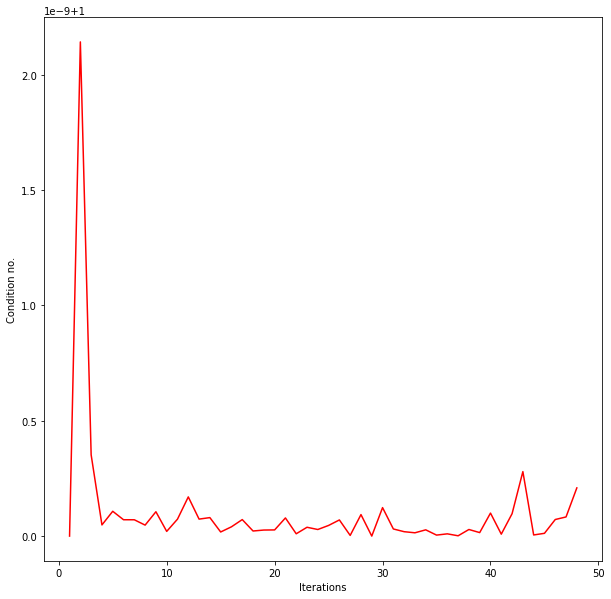

In [52]:
import matplotlib.pyplot as plt #package useful for plotting
plt.figure(figsize=(10, 10))
plt.plot(iterations, condition_no, color='red')
plt.xlabel('Iterations')
plt.ylabel('Condition no.')
plt.show()

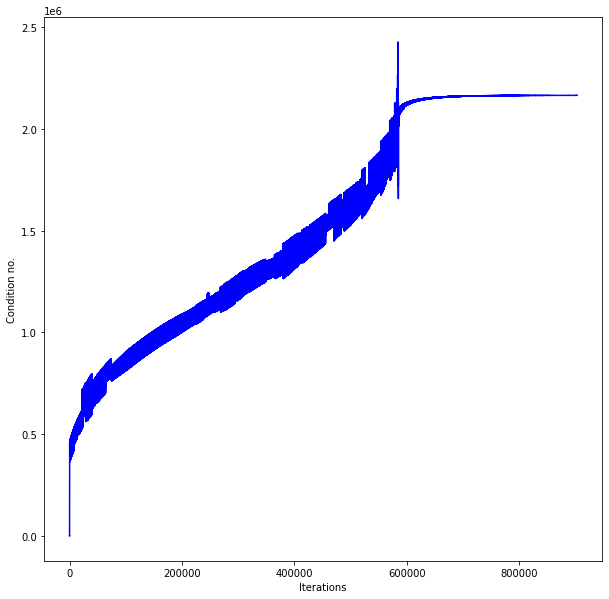

In [54]:
plt.figure(figsize=(10, 10))
plt.plot(iterations1, condition_no1, color='blue')
plt.xlabel('Iterations')
plt.ylabel('Condition no.')
plt.show()

$\text{Observation: In the of Condition number vs number of iterations graph, in case of Backtracking Algorithm with scaling, the number is maximum for iteration close to $0$. For the remaining values it remains close to $1$. Which is the ideal value of condition number.} \\ \text{In case of backtracking Algorithm without scaling, the condition numbers first start increasing   as the number of iterations increase, and then reaches maximum when number of iterations is close to $60000$ and then stabilises around $2\times 10^{6}$.} \\ \text{This very high value of condition number indicates that the number of iterations required will be very high and the process will take very less time. So, we must opt for scaling, so that the convergence to the optimal solution point can be made faster.}$